## download and save data

In [1]:
import os

from tqdm.notebook import tqdm
import pandas as pd
import dask.dataframe as dd

In [6]:
DASK_DATA_DIR = "dask_hdf"

In [3]:
os.makedirs(DASK_DATA_DIR, exist_ok=True)

In [4]:
NPARTITIONS = 4

In [5]:
dfs = ["region_df",
       "competition_df",
       "season_df",
       "round_df",
       "match_df",
       "goal_df",
       "match_info_df",
       "lineup_df",
       "coach_df",
       "sidelined_df",
       "sub_df",
       "event_df",
       "player_df"]

In [ ]:
for dfid in tqdm(dfs):
    url = f"https://borza-hotelcom-data.s3.eu-central-1.amazonaws.com/soccerway-{dfid}.pkl"
    _df = pd.read_pickle(url)
    ddf = dd.from_pandas(_df, npartitions=NPARTITIONS)
    pattern = os.path.join(DASK_DATA_DIR, f"{dfid}-*.h5")
    try:
        ddf.fillna("").to_hdf(pattern, "data")
    except TypeError:
        ddf.to_hdf(pattern, "data")

## plan

### 1. group questions by required detail level of a record:

#### 2. go over again, add + cols needed

- match:
  - number of games with at least 2 missed penalties + miss-pen sum
  - how many previous games in the season + season_id
  - number of different competitions in the region + comp_id, region_id
  - draw rate in the season so far + is_draw
  - average number of yellow cards in a game in the season so far + ycards_num sum


- match × team
  - what is the highest number of left footed players fielded by one team in the same match + is_lefty sum
  - top 5 teams with most penalties missed
  - top 5 teams with most penalties missed against
  - top 5 teams with most average yellow cards per game (at least 20 games)
  - top 5 teams with lowest average number of substitutions per game (at least 20 games) + sub sum
  - top 5 teams with earliest average time of first substitution (at least 20 games) + sub_time min
  - top 5 teams with highest ratio of wins after being behind at half time (at least 20 games) + win, ht_behind

  - the number of games they played in the last 21 days + game date
  - in how many different competitions each team played in the last 21 days
  - days since their last match
  - goal difference in the last 10 matches + goal-diff
  - win rate in last 10 matches + is_win
  - average number of bookings in the last 10 matches + booking sum
  - average time of earliest substitutions in the last 10 games
  - number of different nationalities in starting lineup + nationality nunique
  - how many times the 2 teams have met previously



- match × team × player
  - how many players scored at least 20 goals in 4 different areas + region_id
  - how many players were sent off twice by the same referee + sent-off, referee_id
  - number of players sent off after being substituted
  - top 5 players with number of assists in one season + assist sum, season_id
  - top 5 players with highest number of goals as a substitute + goals sum
  - top 5 players who sat on the bench most number of times for an entire game + full-bench
  - top 5 players with number of goals in first half + firsthalf goals
  - top 5 players with highest number of games where they both scored and assisted
  - **number of goals scored in last 21 days by players sidelined for this match** + is_sidelined, start_time
  - how many times the 2 coaches have met previously + is_coach


- match × team × player × event
  - **how many goals did teams score after having a player sent off**
  - **top 5 players with most different types of reasons for being sidelined**

In [1]:
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd

In [2]:
import os

import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:42511 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.23 GB


In [5]:
DASK_DATA_DIR = "dask_hdf"

In [6]:
lup_cols = [
    "side",
    "match_id",
    "person_id",
    "starter",
    "comes_on",
    "full_bench",
    "sidelined",
    "sub_time",
]

player_cols = [
    "First name",
    "Last name",
    "Nationality",
    "is_lefty",
    "person_id",
]

event_cols = [
    "penalty-miss",
    "yc_all",
    "bookings",
    "sent_off",
    "goal",
    "assist",
    "fh_goal",
]

match_info_cols = [
    "region_id",
    "comp_id",
    "season_id",
    "home_team",
    "away_team",
    "start_time",
    "referee_id",
    "ht_gd",
    "ft_gd",
]

In [9]:
def _get_pattern(s):
    return os.path.join(DASK_DATA_DIR, f"{s}-*.h5")

def _get_data(s):
    return dd.read_hdf(_get_pattern(s), "data")

def _filter_error_rounds(_df):
    return ~(
        (_df["season_id"] == _df["round_id"])
        & _df["round_id"].duplicated(keep=False)
    )


def _get_gd(_s):
    return (
        _s.str.extract(r"([0-9]+) - ([0-9]+)")
        .astype(float)
        .pipe(lambda _df: _df[0] - _df[1])
    )

In [11]:
def _parse_time_int(_df):
    return (
        _df["time"]
        .loc[lambda s: ~s.isin(["'", ""])]
        .str.replace("'", "")
        .map(eval, meta=pd.Series(dtype=float))
    )  # this changed for dask


def _is_first_half(_df):
    return (
        _df["time"].str.replace("'", "").str.split("+").str[0].astype(int)
        <= 45
    )


def _fh_goals(_df):
    return (
        _df.loc[lambda df: (df["event"] == "goal") & (df["time"] != "'"), :]
        .loc[_is_first_half, :]
        .assign(event="fh_goal")
    )

In [12]:
match_info_ddf = (
    _get_data("region_df")
    .merge(_get_data("competition_df"))
    .merge(_get_data("season_df").drop_duplicates(subset=["season_id", "comp_id"]))
    .merge(_get_data("round_df").loc[_filter_error_rounds, :])
    .merge(_get_data("match_df"))
    .merge(
        _get_data("match_info_df").assign(
            ht_gd=lambda df: df["Half-time"].pipe(_get_gd),
            ft_gd=lambda df: df["Full-time"].pipe(_get_gd),
        )
    )
    #.set_index("match_id")  # watch out for this
    #.loc[:, mathc_info_cols]
    .loc[:, ["match_id", *match_info_cols]]
)

In [ ]:
match_info_ddf.visualize(optimize_graph=True)

In [16]:
sidelined_raw_ddf = _get_data("sidelined_df")
player_raw_ddf = _get_data("player_df")

top5_sideline = (  # nunique ditched here - why?
            sidelined_raw_ddf
            .drop_duplicates(subset=["player_id", "reason"])
            .groupby("player_id")[["reason"]].count()
            .nlargest(5, "reason")
            .reset_index()
            .merge(
                player_raw_ddf.loc[
                    :, ["player_id", "First name", "Last name", "Nationality"]
                ],
                how="left",
            )
        )

In [18]:
top5_sideline.compute()

,player_id,reason,First name,Last name,Nationality
0,193,15,Wayne Mark,Rooney,England
1,22357,14,Mario,Barwuah Balotelli,Italy
0,79474,15,Chris,Smalling,England
1,97299,15,Phil,Jones,England
0,20687,15,Jonny,Evans,Northern Ireland


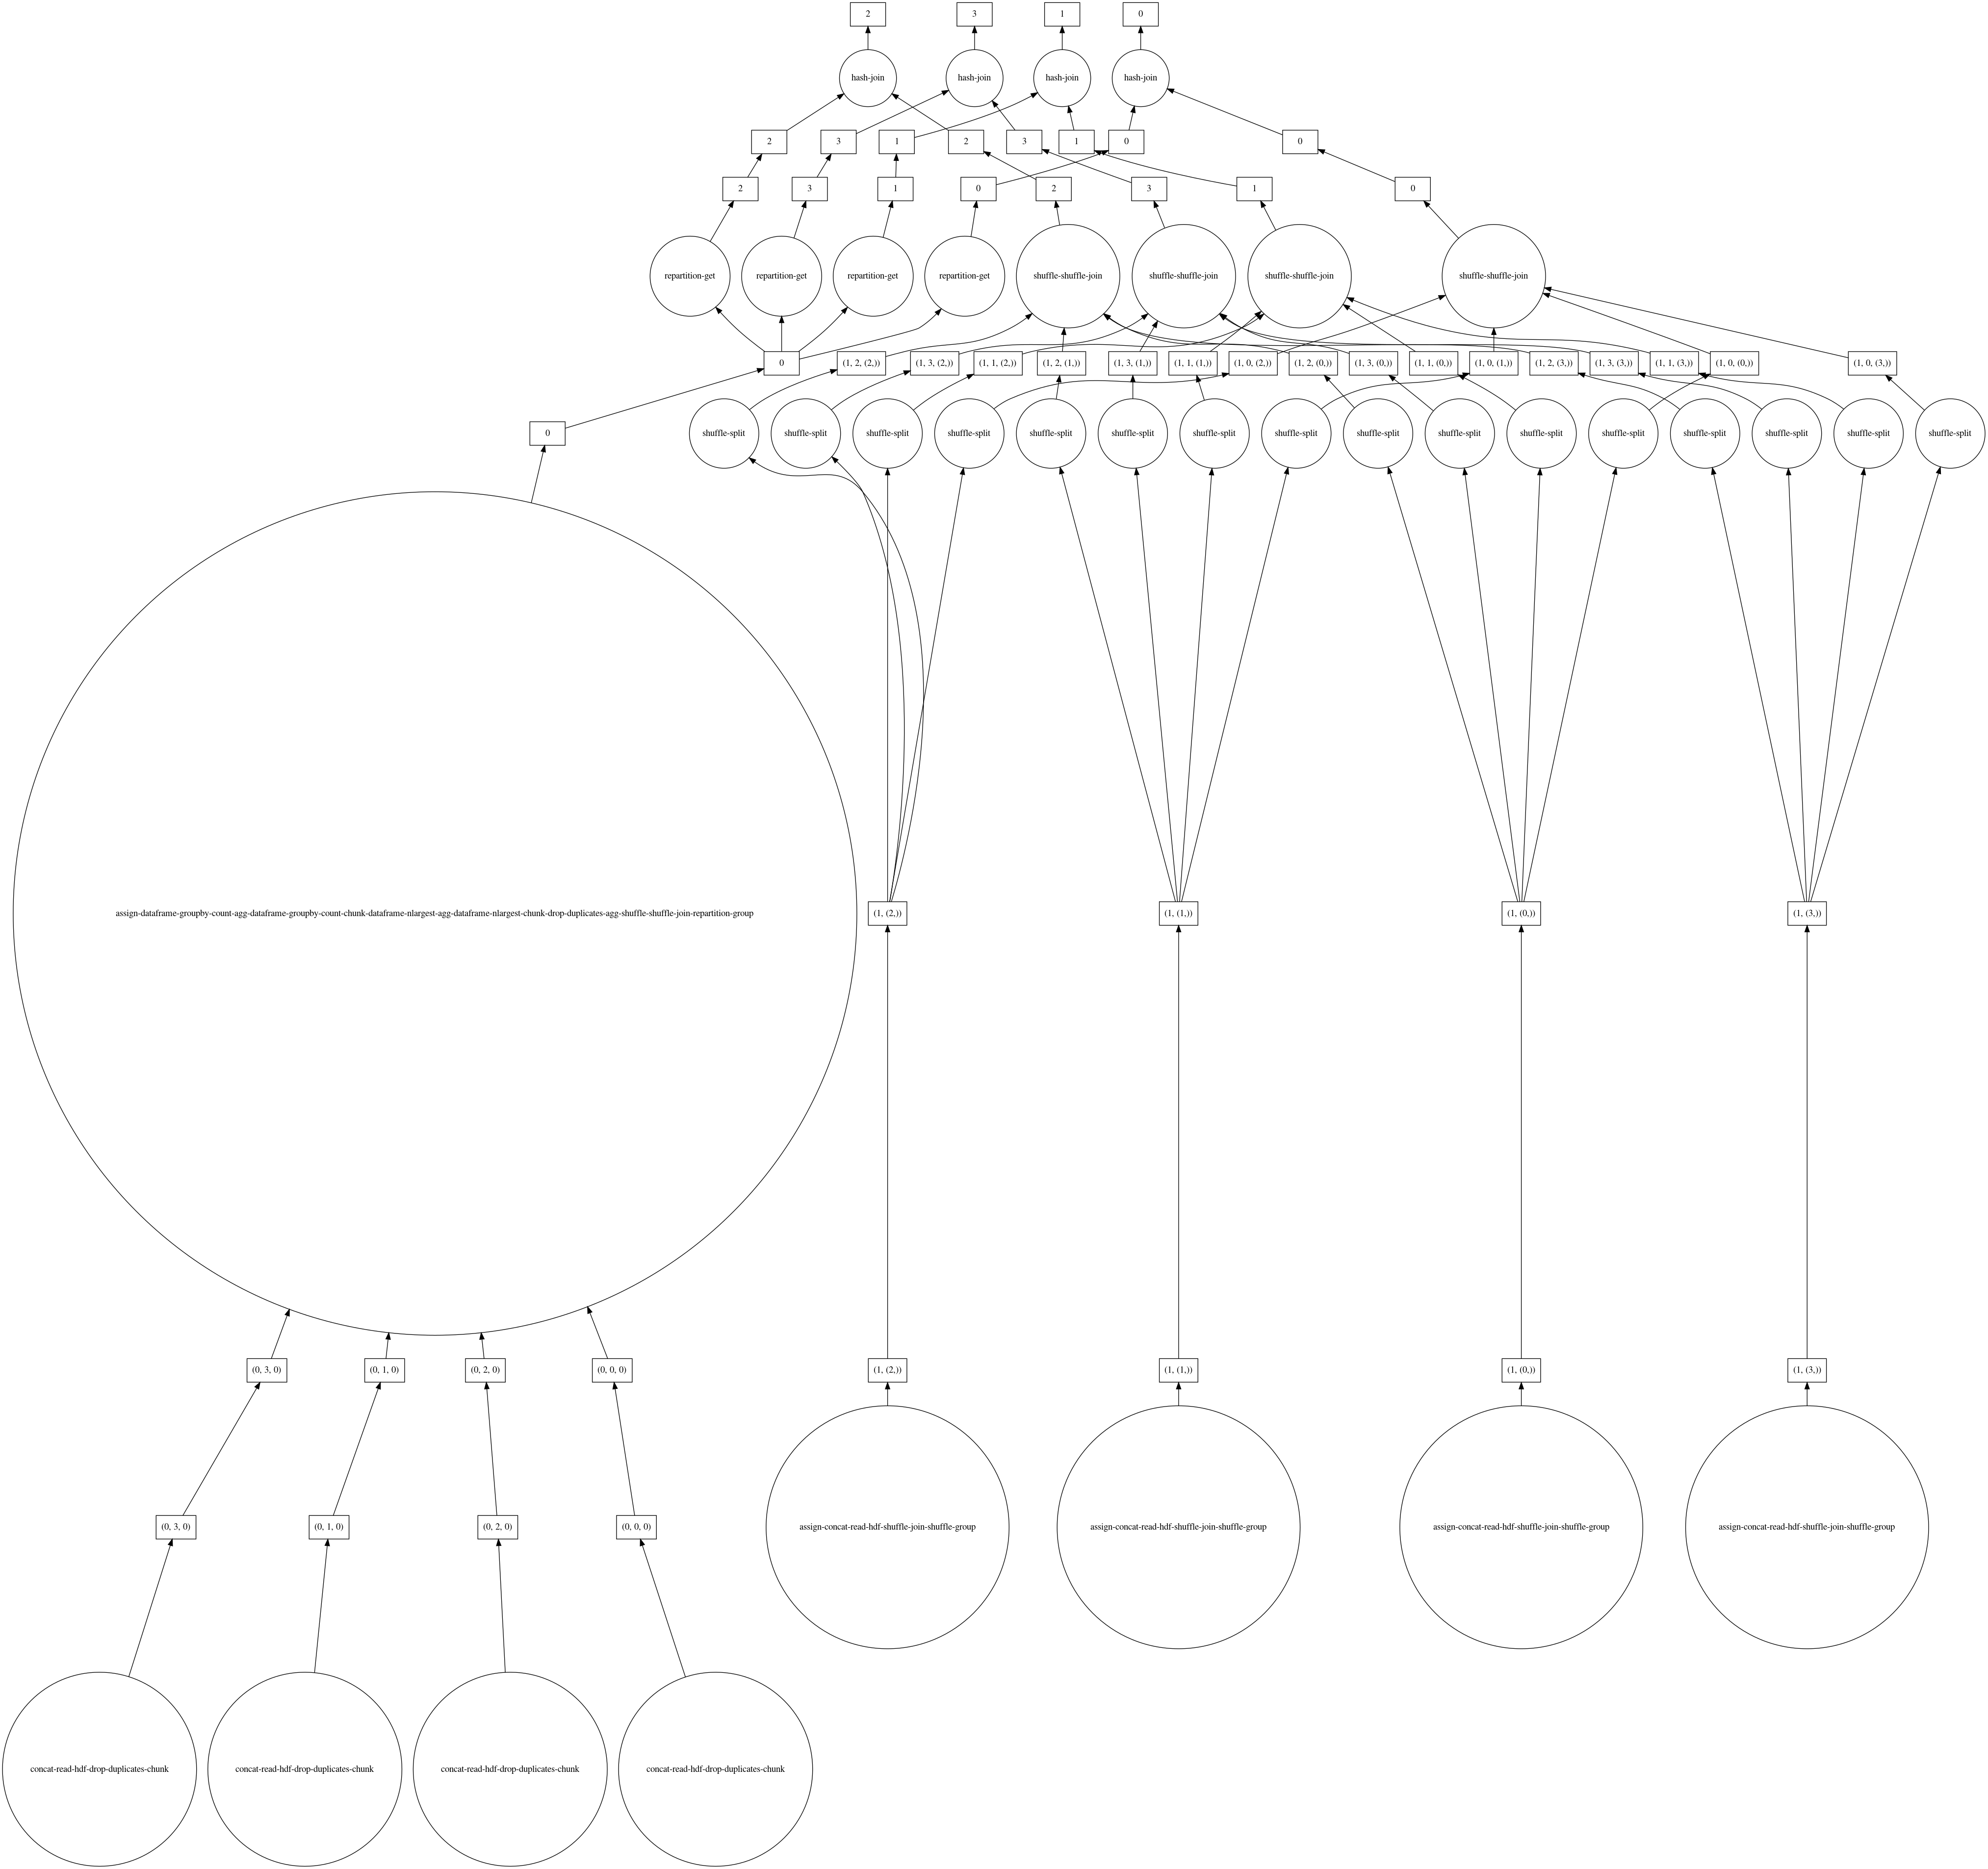

In [19]:
top5_sideline.visualize(optimize_graph=True)

In [20]:
participant_ddf = (
    dd.concat(
        [
            _get_data("lineup_df")
            .assign(
                starter=True,
                comes_on=False,
                full_bench=False,
                sidelined=False,
                sub_time=np.inf,
            )
            .loc[:, lup_cols],
            _get_data("sub_df")
            .rename(columns={"sub_id": "person_id"})
            .assign(
                starter=False,
                comes_on=lambda df: ~df["subbed_id"].isna(),
                full_bench=lambda df: df["subbed_id"].isna(),
                sidelined=False,
                sub_time=_parse_time_int,
            )
            .loc[:, lup_cols],  # note: no need for who was subbed off
            sidelined_raw_ddf.rename(columns={"player_id": "person_id"})
            .assign(
                starter=False,
                comes_on=False,
                full_bench=False,
                sidelined=True,
                sub_time=np.inf,
            )
            .loc[:, lup_cols],
        ]
    )
    .drop_duplicates(subset=["person_id", "match_id", "side"], keep="first")
    .merge(
        player_raw_ddf
        .rename(columns={"player_id": "person_id"})
        .assign(is_lefty=lambda df: (df["Foot"] == "Left").astype(int))
        .loc[:, player_cols],
        how="left",
    )  # here astype(int) saves a LOT of time
)

In [22]:
event_ddf_raw = _get_data("event_df")

In [23]:
def _add_back_id_cols(ddf):
    id_cols = ddf.index.str.extract("([0-9]+)-([0-9]+)").astype(int)
    return ddf.assign(
        match_id=id_cols.loc[:,0].values,
        person_id=id_cols.loc[:, 1].values
    )

In [31]:
%%time
event_ddf = (
    dd.concat(
        [
            event_ddf_raw.pipe(lambda df: dd.concat([df, _fh_goals(df)])),
            _get_data("goal_df")
            .loc[lambda df: df["assister_id"] != "", :]
            .assign(
                event="assist",
                time=lambda df: df["minute"],
                person_id=lambda df: df["assister_id"].astype(int),
            )
            .loc[:, ["match_id", "person_id", "time", "event"]],
        ]
    )
    .categorize(columns=["event"])
    .assign(
        plma=lambda df: df["match_id"].astype(str) + "-" + df["person_id"].astype(str)
    )
    .pivot_table(columns="event", index="plma", values="time", aggfunc="count")
    .rename(columns=str)  # now why is this here
    .pipe(_add_back_id_cols)
    .assign(
        yc=lambda df: (df["y-card"] > 0).astype(int),
        yc2=lambda df: (df["2nd-y-card"] > 0).astype(int),
        rc=lambda df: (df["r-card"] > 0).astype(int),
    )
    .assign(
        bookings=lambda df: df.loc[:, ["yc", "yc2", "rc"]].sum(axis=1),
        sent_off=lambda df: df.loc[:, ["rc", "yc2"]]
        .sum(axis=1)
        .astype(bool)
        .astype(int),
        yc_all=lambda df: df.loc[:, ["yc", "yc2"]].sum(axis=1),
    )
    .loc[:, ["match_id", "person_id", *event_cols]]
)

CPU times: user 2.74 s, sys: 307 ms, total: 3.05 s
Wall time: 12.1 s


In [32]:
coach_ddf = _get_data("coach_df").merge(
    match_info_ddf.loc[:, ["match_id", "start_time"]], how="left"
)

In [37]:
player_x_match_ddf = (
    participant_ddf
    .merge(event_ddf, how="left")
    .merge(match_info_ddf, how="left")
    .assign(
        sub_time=lambda df: df.loc[:, "sub_time"].replace(0, np.inf),
        #sub_goals=lambda df: np.where(df["comes_on"], df["goal"], 0),  #HERE
        sub_goals=lambda df: df["goal"].where(df["comes_on"], 0),
        g_a=lambda df: (df["goal"] > 0) & (df["assist"] > 0),
        come_n_go=lambda df: ((df["sent_off"] > 0) & df["comes_on"]),
    )
)

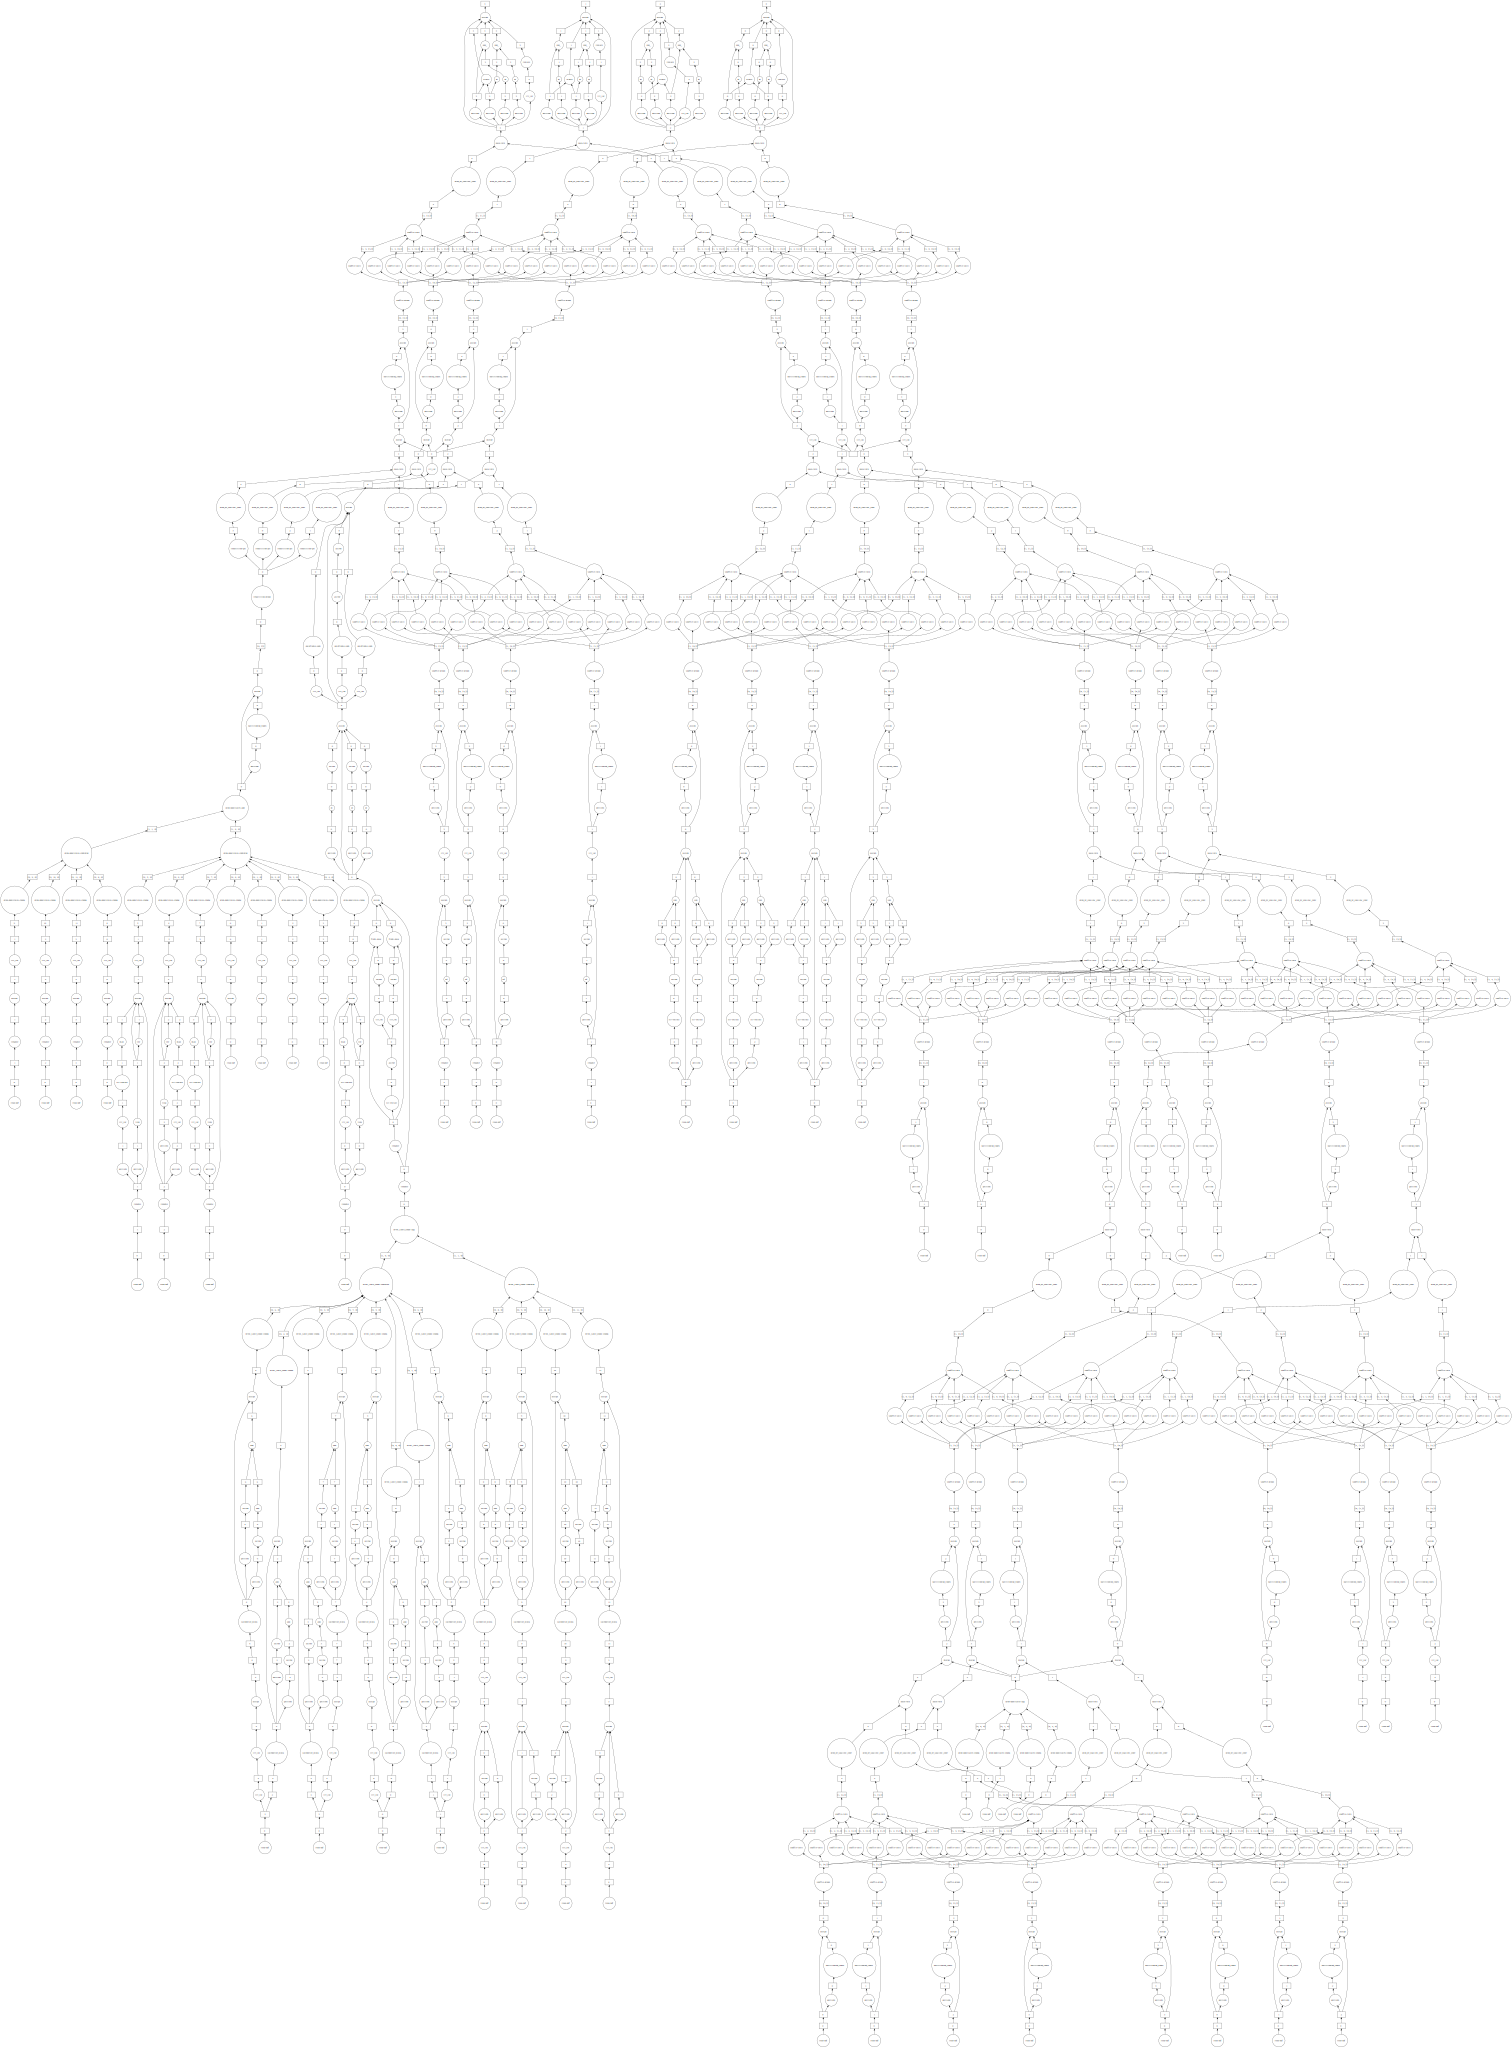

In [39]:
player_x_match_ddf.visualize(format="svg")

## match × team × player × event


  - **how many goals did teams score after having a player sent off**
  - **top 5 players with most different types of reasons for being sidelined**

In [3]:
def _get_goals_after_rc(event_raw, lup_raw):
    sided_rel_events = (
        event_raw.loc[
            lambda df: df["event"].isin(["goal", "r-card", "2nd-y-card"])
            & (df["time"] != "'")
        ]
        .merge(
            lup_raw.loc[:, ["match_id", "person_id", "side"]], how="left",
        )
        .assign(
            event=lambda df: df["event"].replace("2nd-y-card", "r-card")
        )
    )
    time_lists = (
        sided_rel_events["time"].str.replace("'", "").str.split("+")
    )

    pr_arr = (
        sided_rel_events.assign(
            main_time=time_lists.str[0].astype(int),
            plus_time=np.where(
                time_lists.str.len() > 1, time_lists.str[1], "0"
            ).astype(int),
        )
        .sort_values(
            ["match_id", "side", "main_time", "plus_time", "event"]
        )
        .loc[:, ["match_id", "side", "event"]]
        .values
    )

    prg = 0
    pr = False
    for i in range(1, pr_arr.shape[0]):
        if pr_arr[i - 1, 2] == "r-card":
            pr = True
        if (pr_arr[i, 0], pr_arr[i, 1]) != (
            pr_arr[i - 1, 0],
            pr_arr[i - 1, 1],
        ):
            pr = False
        if pr & (pr_arr[i, 2] == "goal"):
            prg += 1

    return prg


8837

In [4]:
dr.top5_sideline

,player_id,reason,First name,Last name,Nationality
0,193,15,Wayne Mark,Rooney,England
1,20687,15,Jonny,Evans,Northern Ireland
2,79474,15,Chris,Smalling,England
3,97299,15,Phil,Jones,England
4,22357,14,Mario,Barwuah Balotelli,Italy


## match × team × player

- number of players sent off after being substituted
- top 5 players with highest number of goals as a substitute
- top 5 players who sat on the bench most number of times for an entire game
- top 5 players with number of goals in first half
- top 5 players with highest number of games where they both scored and assisted


- how many players were sent off twice by the same referee + ref_id
- how many players scored at least 20 goals in 4 different areas + region_id
- top 5 players with number of assists in one season + season_id


- **number of goals scored in last 21 days by players sidelined for this match**
- how many times the 2 coaches have met previously

In [5]:
%%time
person_df = dr.player_x_match.groupby(["person_id", "First name", "Last name"])[
    ["come_n_go", "sub_goals", "full_bench", "fh_goal", "g_a"]
].sum()

CPU times: user 3.72 s, sys: 388 ms, total: 4.11 s
Wall time: 4.11 s


In [6]:
(person_df["come_n_go"] > 0).sum()

3418

In [7]:
for c in person_df.columns[1:]:
    display(HTML(person_df[c].nlargest(5).to_frame().to_html()))

,,,sub_goals
person_id,First name,Last name,
119,Lionel Andrés,Messi Cuccittini,34.0
13690,Kevin,Gameiro,34.0
103171,Álvaro Borja,Morata Martín,34.0
53937,Javier,Hernández Balcázar,31.0
1595,Karim,Benzema,30.0


,,,full_bench
person_id,First name,Last name,
1310,Jessy,Moulin,363.0
18585,Daniele,Padelli,316.0
4336,Marco,Storari,310.0
97650,Rafael Pires,Monteiro,302.0
17587,Germán Darío,Lux,300.0


,,,fh_goal
person_id,First name,Last name,
119,Lionel Andrés,Messi Cuccittini,250.0
382,Cristiano Ronaldo,dos Santos Aveiro,235.0
2290,Luis Alberto,Suárez Díaz,138.0
3051,Sergio Leonel,Agüero del Castillo,137.0
1595,Karim,Benzema,133.0


,,,g_a
person_id,First name,Last name,
119,Lionel Andrés,Messi Cuccittini,93.0
382,Cristiano Ronaldo,dos Santos Aveiro,65.0
2290,Luis Alberto,Suárez Díaz,48.0
102697,Neymar,da Silva Santos Junior,44.0
1595,Karim,Benzema,38.0


- how many players were sent off twice by the same referee
- how many players scored at least 20 goals in 4 different areas (gb region)
- top 5 players with number of assists in one season (gb season)

In [8]:
%%time
dr.player_x_match.groupby(["person_id", "referee_id"])["sent_off"].sum().loc[
    lambda s: s > 1
].index.get_level_values(
    "person_id"
).nunique()

CPU times: user 1.5 s, sys: 40 ms, total: 1.54 s
Wall time: 1.55 s


489

In [9]:
%%time
(
    dr.player_x_match.groupby(["person_id", "First name", "Last name", "region_id"])[
        "goal"
    ]
    .sum()
    .loc[lambda s: s > 20]
    .reset_index()
    .loc[
        lambda df: df["person_id"].isin(
            df.groupby("person_id")["region_id"]
            .count()
            .loc[lambda _s: _s >= 4]
            .index.tolist()
        ),
        :,
    ]
)

CPU times: user 2.12 s, sys: 47.6 ms, total: 2.16 s
Wall time: 2.17 s


,person_id,First name,Last name,region_id,goal
10,40,Miroslav,Klose,1,31.0
11,40,Miroslav,Klose,7,46.0
12,40,Miroslav,Klose,80,60.0
13,40,Miroslav,Klose,100,56.0
132,551,Thierry,Henry,1,22.0
133,551,Thierry,Henry,7,38.0
134,551,Thierry,Henry,68,83.0
135,551,Thierry,Henry,176,36.0
311,2290,Luis Alberto,Suárez Díaz,7,38.0
312,2290,Luis Alberto,Suárez Díaz,68,82.0


In [10]:
%%time
dr.player_x_match.groupby(["person_id", "First name", "Last name", "season_id"])[
    "assist"
].sum().reset_index().sort_values(
    "assist", ascending=False
).drop_duplicates("person_id", keep="first").head(5)

CPU times: user 2.9 s, sys: 42.7 ms, total: 2.95 s
Wall time: 2.94 s


,person_id,First name,Last name,season_id,assist
222302,67424,Luciano,Narsingh,5963,22.0
165062,40709,Dušan,Tadić,5087,21.0
2596,119,Lionel Andrés,Messi Cuccittini,5334,21.0
425904,218727,Zinedine,Ferhat,14061,20.0
157572,38568,Graham,Dorrans,3452,20.0


- **number of goals scored in last 21 days by players sidelined for this match**
- how many times the 2 coaches have met previously

In [11]:
%%time
goals_in_last_21 = dr.player_x_match.loc[
    lambda df: (df["goal"] > 0) | (df["sidelined"] > 0), ["match_id", "person_id", "goal", "date"],
].set_index(
    "date"
).sort_index(
).groupby(
    "person_id"
).rolling("21D")["goal"].sum()

CPU times: user 34.5 s, sys: 96.2 ms, total: 34.6 s
Wall time: 34.6 s


In [12]:
%%time
sideline_feature = goals_in_last_21.reset_index().merge(
    dr.player_x_match.loc[
        lambda df: df["sidelined"] > 0, ["person_id", "date", "match_id", "side"]
    ],
    how="inner",
).groupby(["match_id", "side"])["goal"].sum()

CPU times: user 134 ms, sys: 118 µs, total: 134 ms
Wall time: 133 ms


In [13]:
%%time
coach_feature = (
    dr.coach_df.pipe(
        lambda df: df.reset_index().merge(
            df.rename(columns={"person_id": "opponent"}).assign(
                side=lambda _df: np.where(_df["side"] == "home", "away", "home")
            ),
            how="left",
        )
    )
    .sort_values("date")
    .set_index("index")
    .assign(meeting=1)
    .groupby(["person_id", "opponent"])["meeting"]
    .cumsum()
    .groupby("index")
    .max()
    .pipe(
        lambda s: dr.coach_df.assign(met_opp=s)
        .groupby("match_id")["met_opp"]
        .max()
        .replace(-1, np.nan) - 1
    )
)

CPU times: user 501 ms, sys: 0 ns, total: 501 ms
Wall time: 500 ms


## match × team

  - what is the highest number of left footed players fielded by one team in the same match
  - top 5 teams with most penalties missed
  - top 5 teams with most penalties missed against
  - top 5 teams with most average yellow cards per game (at least 20 games)
  - top 5 teams with lowest average number of substitutions per game (at least 20 games)
  - top 5 teams with earliest average time of first substitution (at least 20 games)
  - top 5 teams with highest ratio of wins after being behind at half time (at least 20 games)

In [14]:
%%time
team_x_match = (
    dr.player_x_match.groupby(["match_id", "side"])
    .agg(
        {
            "is_lefty": "sum",
            "penalty-miss": "sum",
            "yc_all": "sum",
            "bookings": "sum",
            "comes_on": "sum",
            "sub_time": "min",
        }
    )
    .join(
        dr.player_x_match.loc[lambda df: df["starter"], :]
        .groupby(["match_id", "side"])
        .agg({"Nationality": "nunique"})
    )
    .join(dr.match_info)
    .reset_index()
    .assign(
        **{
            "team_id": lambda df: np.where(
                df["side"] == "home", df["home_team"], df["away_team"]
            ),
            "opposition": lambda df: np.where(
                df["side"] == "home", df["away_team"], df["home_team"]
            ),
            "ht_comeback": lambda df: (df["ht_gd"] < 0) & (df["ft_gd"] > 0),
            "win": lambda df: np.where(
                df["side"] == "home", df["ft_gd"] > 0, df["ft_gd"] < 0
            ),
        }
    )
    .sort_values("start_time")
)

CPU times: user 3.75 s, sys: 192 ms, total: 3.95 s
Wall time: 3.95 s


In [15]:
team_x_match["is_lefty"].max()

12.0

In [16]:
# 662 is manchester united...
team_x_match.groupby("team_id")["penalty-miss"].sum().nlargest(5)

team_id
1270    35.0
2017    34.0
2021    29.0
2020    28.0
662     27.0
Name: penalty-miss, dtype: float64

In [17]:
team_x_match.groupby("opposition")["penalty-miss"].sum().nlargest(5)

opposition
2015    28.0
1246    27.0
1244    25.0
1256    24.0
676     23.0
Name: penalty-miss, dtype: float64

In [18]:
team_df = team_x_match.groupby("team_id").agg(
    {
        "match_id": "count",
        "yc_all": "mean",
        "comes_on": "mean",
        "sub_time": lambda s: s.replace(np.inf, np.nan).mean(),
        "ht_comeback": "mean",
    }
).loc[lambda df: df["match_id"] >= 20]

In [19]:
team_df["yc_all"].nlargest(5)

team_id
9713     4.526316
5139     4.238095
11764    4.205128
470      4.125000
14700    4.045455
Name: yc_all, dtype: float64

In [20]:
team_df["comes_on"].nsmallest(5)

team_id
14636    1.000000
19945    1.466667
240      1.542857
9565     1.603774
15896    1.636364
Name: comes_on, dtype: float64

In [21]:
team_df["sub_time"].nsmallest(5)

team_id
44548    38.384615
44534    41.500000
5146     41.571429
15487    41.619048
15136    41.974359
Name: sub_time, dtype: float64

In [22]:
team_df["ht_comeback"].nlargest(5)

team_id
14950    0.150000
18351    0.142857
4415     0.136364
13163    0.136364
15805    0.136364
Name: ht_comeback, dtype: float64

- the number of games they played in the last 21 days
- in how many different competitions each team played in the last 21 days
- days since their last match

In [23]:
%%time
team_x_match.set_index("start_time").sort_index().groupby("team_id").rolling("21D").agg(
    {
        "match_id": "count",
        # "comp_id": "nunique"  - this is not implemented yet in pandas :(
    }
)

CPU times: user 3.04 s, sys: 4.08 ms, total: 3.05 s
Wall time: 3.05 s


match_id
team_id start_time                   
66      2011-03-23 09:30:00       1.0
        2011-03-25 09:30:00       2.0
        2011-04-07 09:45:00       3.0
        2011-04-09 09:45:00       4.0
        2011-04-11 09:45:00       5.0
...                               ...
49225   2019-04-18 10:00:00       2.0
49226   2019-02-13 17:00:00       1.0
        2019-02-15 11:00:00       2.0
        2019-04-16 12:00:00       1.0
        2019-04-18 10:00:00       2.0

[301154 rows x 1 columns]

In [24]:
team_x_match.groupby("team_id")["start_time"].diff(1).dropna()

4720      3 days 00:00:00
4714      3 days 00:00:00
4705      2 days 00:00:00
4704      4 days 00:00:00
4722      3 days 00:00:00
               ...       
301152   24 days 09:45:00
301112    3 days 00:15:00
301113    3 days 03:00:00
301115    3 days 03:00:00
301114    3 days 05:45:00
Name: start_time, Length: 296298, dtype: timedelta64[ns]

- goal difference in the last 10 matches
- win rate in last 10 matches
- average number of bookings in the last 10 matches
- average time of earliest substitutions in the last 10 games

In [25]:
%%time
team_x_match.groupby("team_id").rolling(10).agg(
    {"ft_gd": "sum", "win": "mean", "bookings": "mean", "sub_time": "mean"}
).dropna()

CPU times: user 10.4 s, sys: 3.84 ms, total: 10.4 s
Wall time: 10.4 s


ft_gd  win  bookings  sub_time
team_id                                       
66      163455    1.0  0.6       2.1      55.5
        163459    4.0  0.5       2.0      51.2
        163460    4.0  0.4       1.9      52.8
        163465    5.0  0.4       1.9      56.7
        239211    6.0  0.3       1.9      58.6
...               ...  ...       ...       ...
44602   290820   -6.0  0.6       0.7      60.2
        290829   -6.0  0.6       0.8      57.5
        290846   -6.0  0.5       1.0      56.6
45568   297937    4.0  0.3       4.0      53.0
        297938    4.0  0.2       3.7      54.0

[256787 rows x 4 columns]

- number of different nationalities in starting lineup
- how many times the 2 teams have met previously

In [26]:
team_x_match["Nationality"]#.value_counts()

4700      1
4712      1
4713      1
4719      1
4718      1
         ..
301152    4
301112    1
301113    1
301115    1
301114    1
Name: Nationality, Length: 301154, dtype: int64

In [27]:
team_x_match.assign(
    meeting=1
).groupby(
    ["team_id", "opposition"]
)[
    "meeting"
].cumsum()#.sort_values()

4700      1
4712      1
4713      1
4719      1
4718      1
         ..
301152    7
301112    4
301113    4
301115    5
301114    5
Name: meeting, Length: 301154, dtype: int64

## match

- number of games with at least 2 missed penalties
- number of different competitions in the region

In [28]:
team_x_match.groupby("match_id")["penalty-miss"].sum().pipe(lambda s: (s >=2).sum())

148

In [29]:
team_x_match.groupby("region_id")["comp_id"].nunique()

region_id
1      62
2      18
3      13
4      20
5      10
6       6
7      24
16      8
19      1
21      1
26      2
27      2
35     42
48      2
49      1
51      1
58      1
59      1
61      1
68     33
75      2
76     11
79      1
80     20
82      1
92      1
93      1
98      1
100    13
111     1
120     1
126     1
138    16
145     1
146     1
150     1
155     2
156     3
160     2
165     3
170     1
171     1
175     1
176    11
184     3
196     3
201     2
203     1
204     1
209     1
Name: comp_id, dtype: int64

- how many previous games in the season
- draw rate in the season so far
- average number of yellow cards in a game in the season so far


In [30]:
%%time
team_x_match.groupby(["match_id", "season_id"]).agg(
    {"yc_all": "sum", "ft_gd": "mean"}
).assign(draw=lambda df: (df["ft_gd"] == 0).astype(int), count=1).groupby(
    "season_id"
).expanding().agg(
    {"yc_all": "mean", "draw": "mean", "count": "sum"}
).reset_index(
    [0, 2], drop=True
)

CPU times: user 2.84 s, sys: 0 ns, total: 2.84 s
Wall time: 2.84 s


,yc_all,draw,count
match_id,,,
1225,6.000000,0.000000,1.0
1226,5.500000,0.500000,2.0
1227,5.666667,0.333333,3.0
1228,6.750000,0.500000,4.0
1229,6.000000,0.400000,5.0
...,...,...,...
1348604,6.318792,0.291946,298.0
1348605,6.311037,0.290970,299.0
1348606,6.300000,0.290000,300.0


### * this thing is used at coach_feature

In [31]:
_df = pd.DataFrame({
    "x": list("ijjijjijji"),
    "y": ["a", "a", "b", "a", "a", np.nan, "a", "b", "b", "a"],
    "n": [1,1,1,1,1,1,1,1,1,1]
})

In [32]:
_df.assign(cumsum=lambda df: df.groupby(["x", "y"])["n"].cumsum().to_frame()).assign(
    note=lambda df: np.where(df["cumsum"] < 0, "<-- THIS SHIT", "")
)

,x,y,n,cumsum,note
0,i,a,1,1,
1,j,a,1,1,
2,j,b,1,1,
3,i,a,1,2,
4,j,a,1,2,
5,j,NaN,1,-1,<-- THIS SHIT
6,i,a,1,3,
7,j,b,1,2,
8,j,b,1,3,
9,i,a,1,4,
